In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt


In [3]:
import numpy as np

In [4]:
import torch
from sklearn.preprocessing import MinMaxScaler

In [5]:
import torch.nn as nn


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Loading

In [7]:
file_path = '/kaggle/input/nvidia-daily-stock-price-data/nvidia_stock_prices.csv'
df = pd.read_csv(file_path)

# Functions

In [8]:
def create_sequences(data, look_back=60):
    sequences = []
    labels = []
    for i in range(look_back, len(data)):
        sequences.append(data[i-look_back:i])
        labels.append(data[i])
    return np.array(sequences), np.array(labels)

In [9]:
def calculate_regression_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().detach().numpy()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mse, mae, rmse, r2

In [10]:
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, batch_size=64, learning_rate=0.001):
    criterion = nn.MSELoss()  # Use MSE for regression loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics for plotting later
    train_losses = []
    val_losses = []
    train_maes = []
    train_rmses = []
    train_r2s = []
    
    val_maes = []
    val_rmses = []
    val_r2s = []

    for epoch in range(num_epochs):
        model.train()
        
        # Forward pass and loss calculation
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate training metrics
        mse, mae, rmse, r2 = calculate_regression_metrics(y_train, outputs)
        train_maes.append(mae)
        train_rmses.append(rmse)
        train_r2s.append(r2)
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_losses.append(val_loss.item())
            
            # Calculate validation metrics
            val_mse, val_mae, val_rmse, val_r2 = calculate_regression_metrics(y_test, val_outputs)
            val_maes.append(val_mae)
            val_rmses.append(val_rmse)
            val_r2s.append(val_r2)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
                  f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}')
    
    # Return all metrics for plotting later
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'train_rmses': train_rmses,
        'train_r2s': train_r2s,
        'val_maes': val_maes,
        'val_rmses': val_rmses,
        'val_r2s': val_r2s
    }

In [11]:
def plot_metrics(metrics):
    epochs = range(len(metrics['train_losses']))

    plt.figure(figsize=(12, 8))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['train_losses'], label='Train Loss')
    plt.plot(epochs, metrics['val_losses'], label='Validation Loss')
    plt.title('Loss (MSE)')
    plt.legend()

    # Plot MAE
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['train_maes'], label='Train MAE')
    plt.plot(epochs, metrics['val_maes'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.legend()

    # Plot RMSE
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['train_rmses'], label='Train RMSE')
    plt.plot(epochs, metrics['val_rmses'], label='Validation RMSE')
    plt.title('Root Mean Squared Error')
    plt.legend()

    # Plot R-squared
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['train_r2s'], label='Train R²')
    plt.plot(epochs, metrics['val_r2s'], label='Validation R²')
    plt.title('R-squared')
    plt.legend()

    plt.tight_layout()
    plt.show()

# EDA

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-01-02,0.196417,0.199083,0.192333,0.192333,436416000
1,2004-01-05,0.195250,0.199917,0.193500,0.198583,575292000
2,2004-01-06,0.198000,0.209417,0.197083,0.206667,1093344000
3,2004-01-07,0.204333,0.209500,0.202917,0.208500,673032000
4,2004-01-08,0.211083,0.212083,0.207250,0.209250,433752000


In [13]:
summary_stats = df.describe()


In [14]:
missing_values = df.isnull().sum()


In [15]:
df['Date'] = pd.to_datetime(df['Date'])


In [16]:
correlation_matrix = df.corr()


In [17]:
summary_stats, missing_values, correlation_matrix


(              Open         High          Low        Close        Volume
 count  5033.000000  5033.000000  5033.000000  5033.000000  5.033000e+03
 mean      5.214671     5.308604     5.117086     5.217039  5.587962e+08
 std       9.643976     9.811276     9.465058     9.644928  3.363408e+08
 min       0.080583     0.083917     0.077500     0.078583  4.564400e+07
 25%       0.344000     0.349000     0.336500     0.343250  3.482920e+08
 50%       0.544000     0.552750     0.532500     0.542000  4.910920e+08
 75%       5.233750     5.296500     5.125000     5.229000  6.816760e+08
 max      50.216000    50.548000    49.411999    50.409000  5.088948e+09,
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64,
             Date      Open      High       Low     Close    Volume
 Date    1.000000  0.689973  0.690544  0.689831  0.690317 -0.261762
 Open    0.689973  1.000000  0.999843  0.999824  0.999600 -0.127345
 High    0.690544  0.999843  1.000000  0.9997

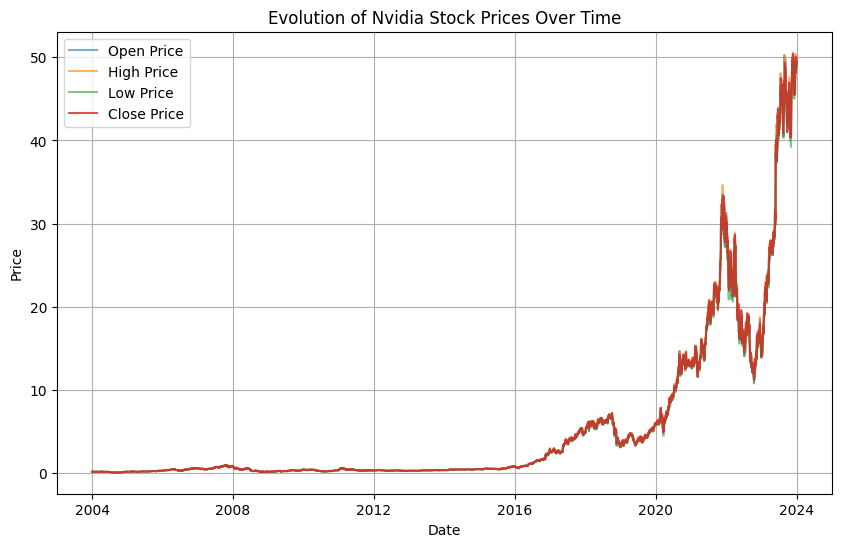

In [18]:
plt.figure(figsize=(10,6))

plt.plot(df['Date'], df['Open'], label='Open Price', alpha=0.6)
plt.plot(df['Date'], df['High'], label='High Price', alpha=0.6)
plt.plot(df['Date'], df['Low'], label='Low Price', alpha=0.6)
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.8)

plt.title('Evolution of Nvidia Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Calculating daily returns as the percentage change of the 'Close' prices
df['Daily_Return'] = df['Close'].pct_change()


In [20]:
# Calculating the rolling volatility (standard deviation of daily returns)
df['Volatility'] = df['Daily_Return'].rolling(window=30).std()


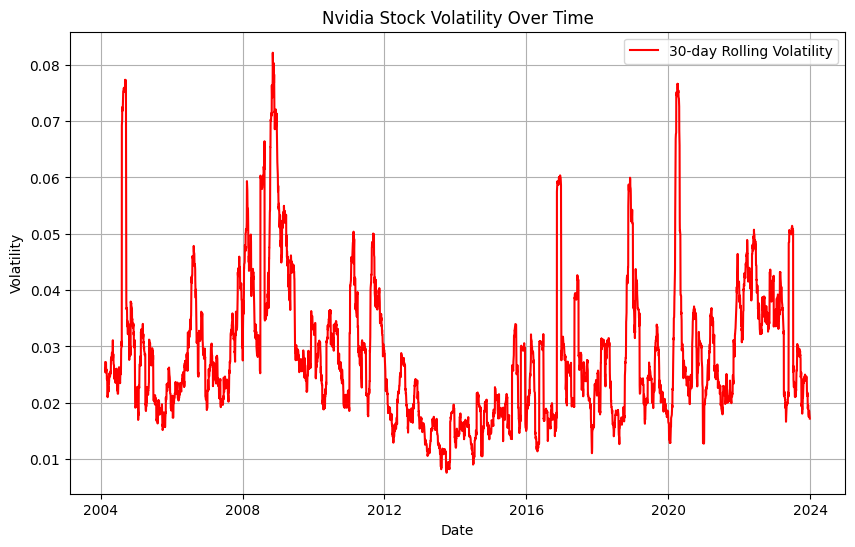

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Volatility'], label='30-day Rolling Volatility', color='red')

plt.title('Nvidia Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Calculating moving averages (50-day and 200-day)
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

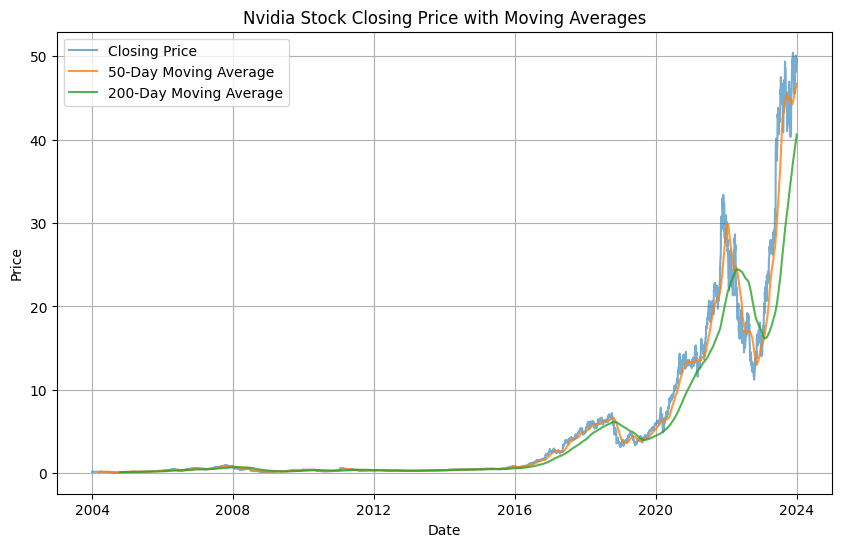

In [23]:
plt.figure(figsize=(10,6))

plt.plot(df['Date'], df['Close'], label='Closing Price', alpha=0.6)
plt.plot(df['Date'], df['MA50'], label='50-Day Moving Average', alpha=0.8)
plt.plot(df['Date'], df['MA200'], label='200-Day Moving Average', alpha=0.8)

plt.title('Nvidia Stock Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Ensure 'Date' is properly set as a datetime object and set it as the index for time-based operations
df['Date'] = pd.to_datetime(df['Date'])


In [25]:
# Extracting the month for each date
df['Month'] = df['Date'].dt.month


In [26]:
# Recalculate the monthly average closing prices
monthly_avg = df.groupby('Month')['Close'].mean()


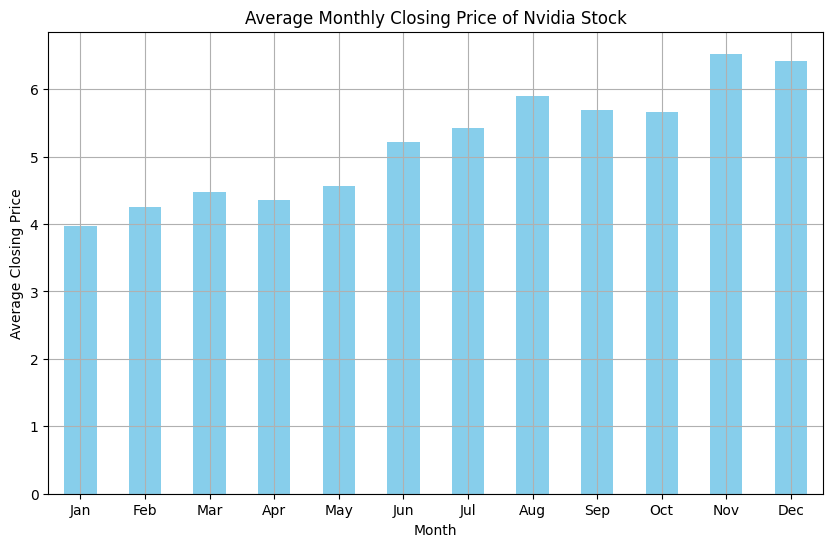

In [27]:
# Plotting the monthly average closing prices
plt.figure(figsize=(10,6))
monthly_avg.plot(kind='bar', color='skyblue')

plt.title('Average Monthly Closing Price of Nvidia Stock')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(True)
plt.show()

In [28]:
df['Year'] = df['Date'].dt.year

In [29]:
yearly_avg = df.groupby('Year')['Close'].mean()

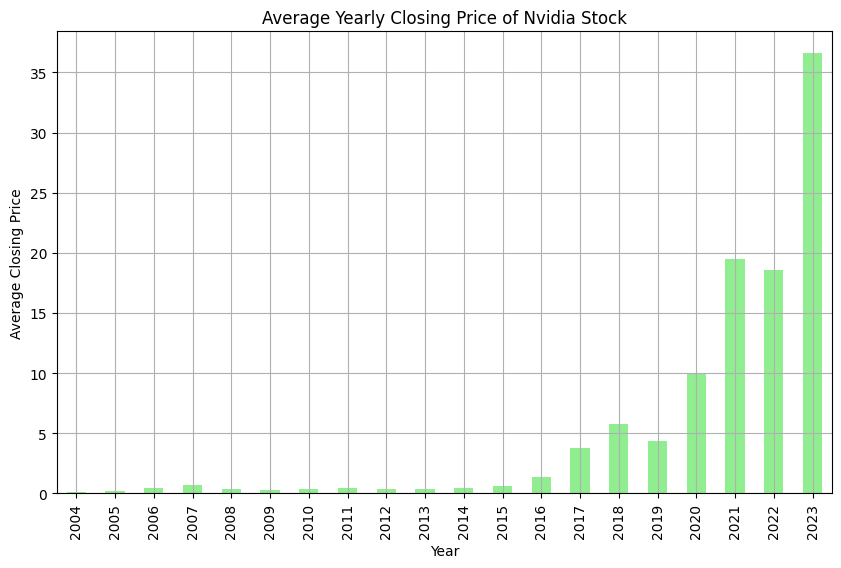

In [30]:
plt.figure(figsize=(10,6))
yearly_avg.plot(kind='bar', color='lightgreen')

plt.title('Average Yearly Closing Price of Nvidia Stock')
plt.xlabel('Year')
plt.ylabel('Average Closing Price')
plt.grid(True)
plt.show()

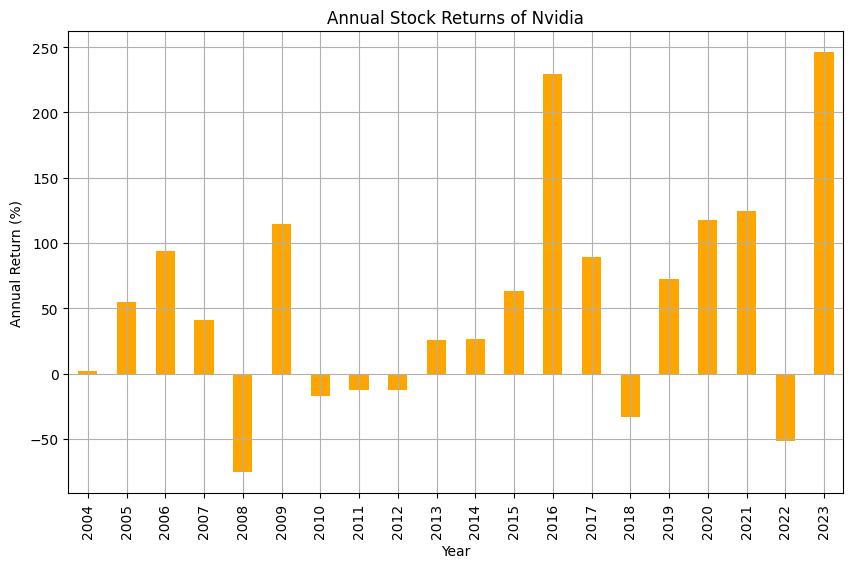

In [31]:
# Calculating the annual return based on the closing prices at the start and end of each year
df_yearly = df.groupby('Year').agg({'Close': ['first', 'last']})

# Calculating the percentage change (return) for each year
df_yearly['Annual_Return'] = (df_yearly['Close']['last'] - df_yearly['Close']['first']) / df_yearly['Close']['first'] * 100

# Plotting the annual returns
plt.figure(figsize=(10,6))
df_yearly['Annual_Return'].plot(kind='bar', color='orange')

plt.title('Annual Stock Returns of Nvidia')
plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.grid(True)
plt.show()


# Data Preprocessing

In [32]:
data = df['Close'].values

In [33]:
# Normalize the data (Close prices)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

In [34]:
look_back = 120
X, y = create_sequences(scaled_data, look_back)

In [35]:
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM Model

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer (return_sequences=True equivalent)
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)

        # Second LSTM layer (return_sequences=False equivalent)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)

        # Final Dense layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Pass through the first LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        out = self.dropout1(out)

        # Pass through the second LSTM layer
        out, (hn, cn) = self.lstm2(out)
        out = self.dropout2(out)

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])

        return out

In [38]:
model = LSTMModel()
criterion = nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
model

LSTMModel(
  (lstm1): LSTM(1, 100, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 100, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Epoch [10/100], Loss: 0.0085, MAE: 0.0639, RMSE: 0.0921, R²: 0.2121
Epoch [20/100], Loss: 0.0027, MAE: 0.0428, RMSE: 0.0518, R²: 0.7513
Epoch [30/100], Loss: 0.0010, MAE: 0.0240, RMSE: 0.0314, R²: 0.9088
Epoch [40/100], Loss: 0.0004, MAE: 0.0150, RMSE: 0.0209, R²: 0.9594
Epoch [50/100], Loss: 0.0003, MAE: 0.0110, RMSE: 0.0173, R²: 0.9723
Epoch [60/100], Loss: 0.0002, MAE: 0.0103, RMSE: 0.0143, R²: 0.9810
Epoch [70/100], Loss: 0.0002, MAE: 0.0097, RMSE: 0.0138, R²: 0.9823
Epoch [80/100], Loss: 0.0002, MAE: 0.0092, RMSE: 0.0134, R²: 0.9833
Epoch [90/100], Loss: 0.0002, MAE: 0.0092, RMSE: 0.0136, R²: 0.9829
Epoch [100/100], Loss: 0.0002, MAE: 0.0089, RMSE: 0.0130, R²: 0.9842


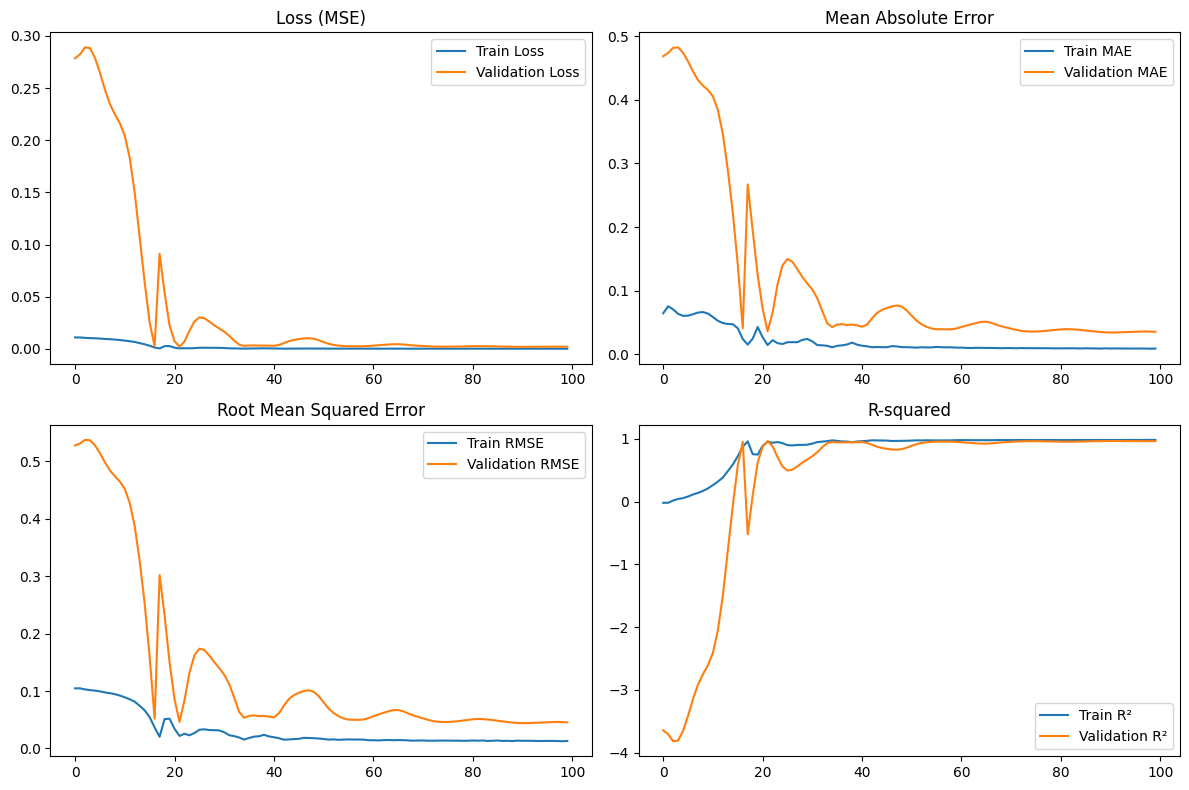

In [40]:
metrics = train_model(model, X_train, y_train, X_test, y_test, num_epochs=100)
plot_metrics(metrics)

In [41]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

In [42]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))


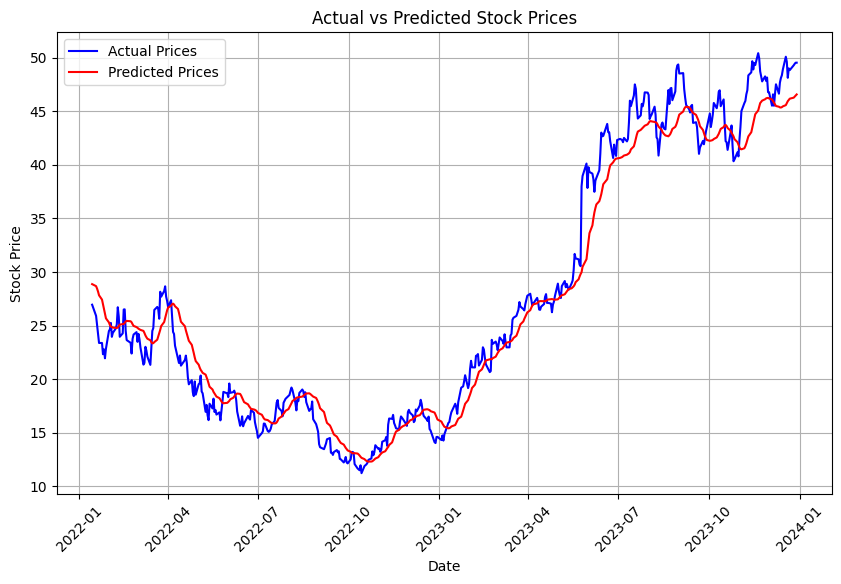

In [43]:
dates = df['Date'][-len(y_test):].values  

plt.figure(figsize=(10,6))
plt.plot(dates, y_test_actual, label='Actual Prices', color='blue')
plt.plot(dates, predictions, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Bidirectional LSTM Model

In [44]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, num_layers=2, dropout=0.25):
        super(BidirectionalLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer (input size is doubled due to bidirectionality)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Pass through the bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout
        out = self.dropout(out)

        # Take the output from the last time step
        out = self.fc(out[:, -1, :])

        return out

In [45]:
model = BidirectionalLSTMModel(input_size=1, hidden_size=100, output_size=1, num_layers=2, dropout=0.25)

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Epoch [10/100], Loss: 0.0103, MAE: 0.0725, RMSE: 0.1015, R²: 0.0434
Epoch [20/100], Loss: 0.0088, MAE: 0.0578, RMSE: 0.0940, R²: 0.1801
Epoch [30/100], Loss: 0.0048, MAE: 0.0452, RMSE: 0.0689, R²: 0.5592
Epoch [40/100], Loss: 0.0027, MAE: 0.0284, RMSE: 0.0522, R²: 0.7468
Epoch [50/100], Loss: 0.0009, MAE: 0.0209, RMSE: 0.0305, R²: 0.9139
Epoch [60/100], Loss: 0.0003, MAE: 0.0121, RMSE: 0.0181, R²: 0.9697
Epoch [70/100], Loss: 0.0003, MAE: 0.0115, RMSE: 0.0169, R²: 0.9734
Epoch [80/100], Loss: 0.0002, MAE: 0.0104, RMSE: 0.0147, R²: 0.9799
Epoch [90/100], Loss: 0.0002, MAE: 0.0091, RMSE: 0.0136, R²: 0.9829
Epoch [100/100], Loss: 0.0002, MAE: 0.0085, RMSE: 0.0134, R²: 0.9834


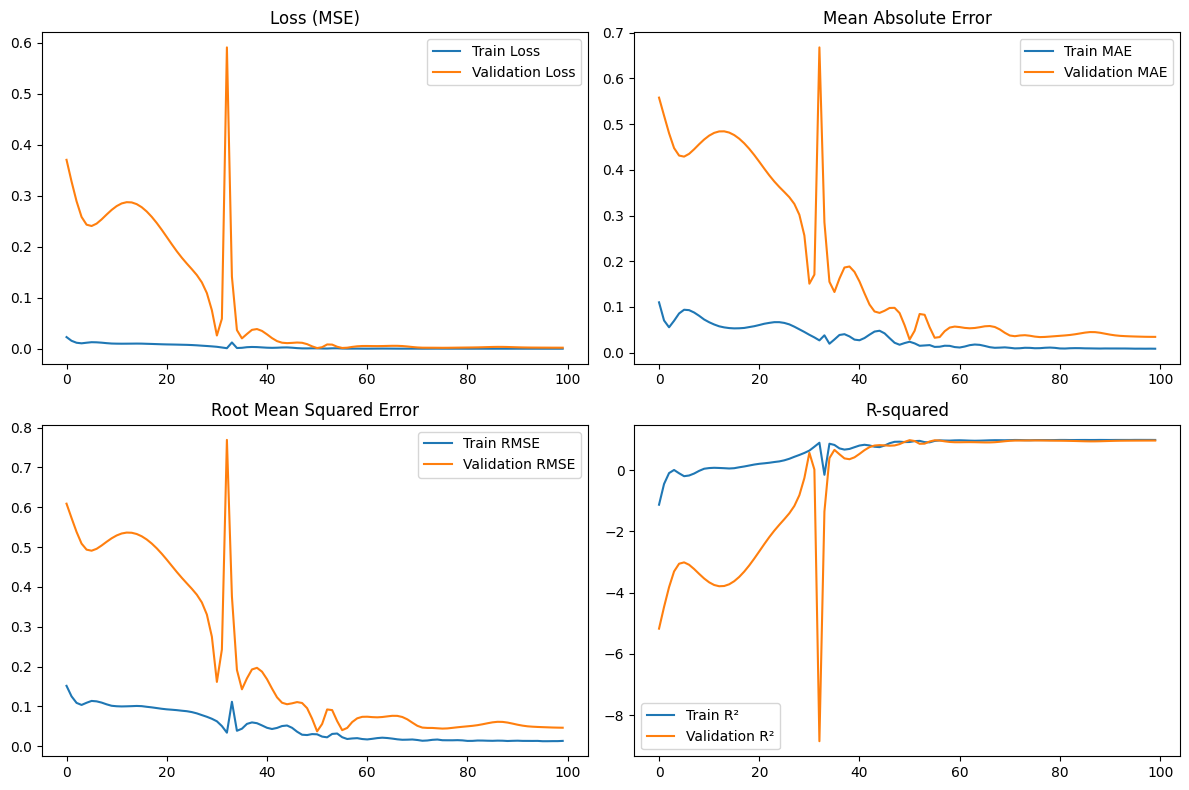

In [47]:
metrics = train_model(model, X_train, y_train, X_test, y_test, num_epochs=100)
plot_metrics(metrics)

In [48]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

In [49]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))


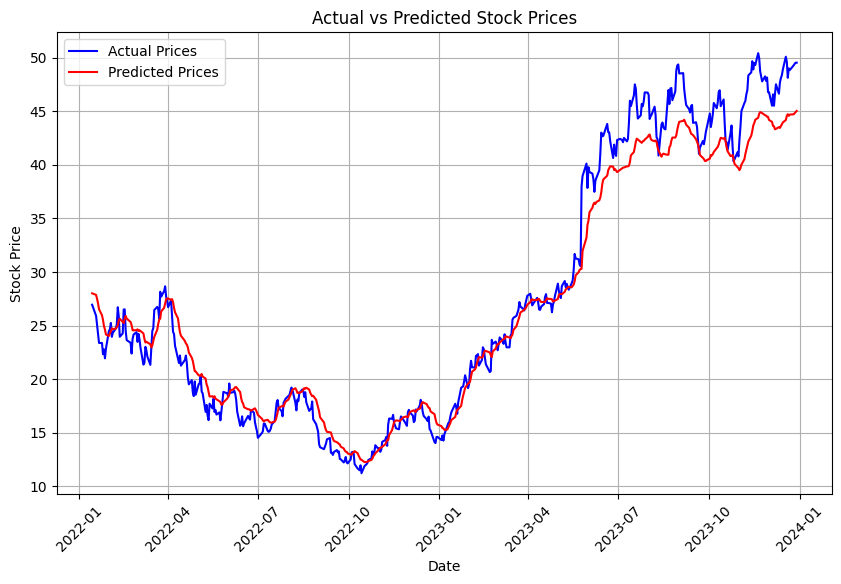

In [50]:
dates = df['Date'][-len(y_test):].values  

plt.figure(figsize=(10,6))
plt.plot(dates, y_test_actual, label='Actual Prices', color='blue')
plt.plot(dates, predictions, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()